## Frequency/Period analysis with modified Hamiltonian

These are systems with a contact Hamiltonian of the form
$$
H = ps + f(q)s + F(q, t)
$$

We will focus in particular on the Van der Pol oscillator
where $f(q) = - \epsilon (1-q^2)$ and $F(q) = q - \phi(t)$.

In [1]:
from numba import jit, prange

In [2]:
from integrators import contact as ic
from integrators.common import rk4
from lienard import integrator as li
from lienard import models as lm

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

def step6e(system, dt, p, q, s, t, a=ic.e_six, stepper=li.step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

Lienard = lm.Lienard
VanDerPol = lm.VanDerPol
FritzhughNagumo = lm.FritzhughNagumo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as si
from mpl_toolkits import mplot3d

import progressbar
import warnings

In [4]:
def err(x, y):
    return np.maximum.accumulate(np.abs(x-y))

In [5]:
def omega(t,e,n):
    o=0
    if n>=2:
        o+=((1 - e**2/16. + (17*e**4)/3072. + t**2/24. + (27*e**2*t**2)/128. +
    (781*e**4*t**2)/73728.))/(2*np.pi)
    if n>=4:
        o+=(((3*t**4)/640. + (149*e**2*t**4)/2048. -
        (339041*e**4*t**4)/3.538944e6))/(2*np.pi)
    if n>=6:
        o+=(((5*t**6)/7168. + (559*e**2*t**6)/16384. +
        (4695149*e**4*t**6)/8.4934656e7))/(2*np.pi)
    return o

omega2 = lambda t, e: omega(t,e,3)
omega4 = lambda t, e: omega(t,e,5)
omega6 = lambda t, e: omega(t,e,7)

In [12]:
@jit(parallel=True, forceobj=True) # forceobj: slower but nopython requires too many lowlevel changes
def compute_periods(system, init, dts, tf):

    periods = np.zeros_like(dts)

    for i in prange(len(dts)):
        
        dt = dts[i]
        p,q,s,t = init
        p1,q1,s1,t1 = li.step1(system, dt, p, q, s, t)

        t_local_max_hit = []
        # We consider the first hit as the start
        # => Big Fail if we only have one hit
        n_max_hit = -1

        while t1 < tf:
            # You can change the integrator used below
            # with the optional argument mapper=li.cbabc

            # perform the next step
            p2,q2,s2,t2 = li.step1(system, dt, p1, q1, s1, t1)

            if s1>s and s1>s2:
                if not t_local_max_hit:
                    # the list is empty, we initialize also the second element to 0,
                    # if there is no second it, we fail in any case by a division by 0...
                    t_local_max_hit = [t1,0.0]
                else:
                    t_local_max_hit[1] = t1
                n_max_hit += 1

            # advance the steps chain
            p,q,s,t = p1,q1,s1,t1
            p1,q1,s1,t1 = p2,q2,s2,t2

        #computate the period by averaging
        if n_max_hit <= 0:
            warnings.warn("Only one maximum was hit with dt={}. Skipping...".format(dt))
        else:
            tl, tr = t_local_max_hit
            period = (tr - tl)/n_max_hit
            periods[i] = period
        
    return periods

## $\epsilon = 0$ Harmonic Oscillator

In [16]:
vdp = VanDerPol(0.0, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 20000

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods00 = np.load(f"data/datapar/eps0-{tf}.npy")
except FileNotFoundError:
    periods00 = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/datapar/eps0-{tf}", periods00)

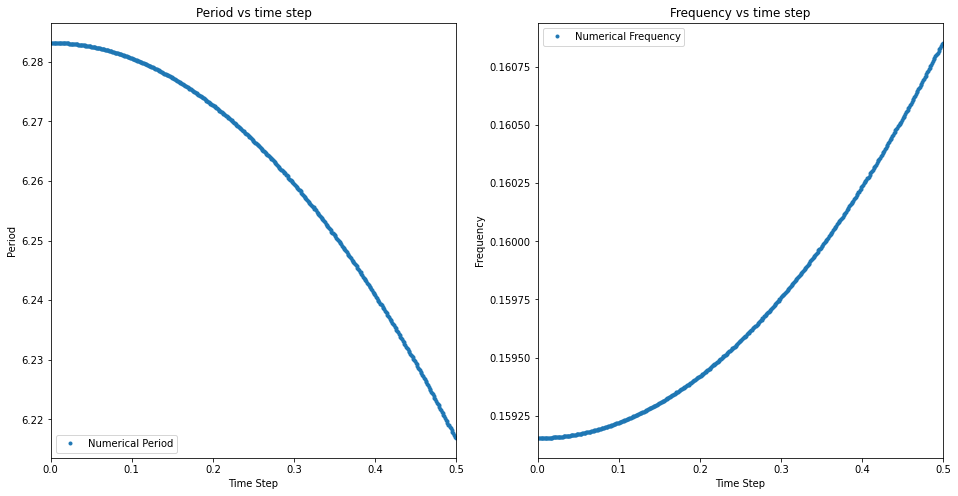

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods00,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods00,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

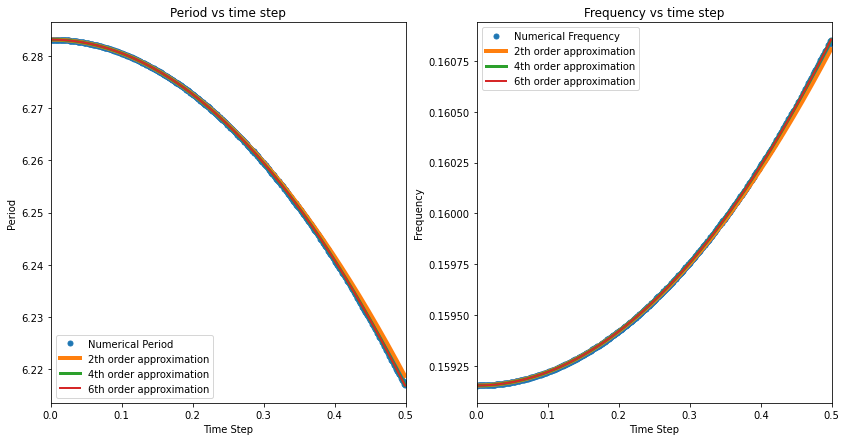

In [18]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods00,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/omega2(dts,0),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/omega4(dts,0),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/omega6(dts,0),
         label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods00,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,omega2(dts,0),
        label="2th order approximation",linewidth=4)
plt.plot(dts,omega4(dts,0),
        label="4th order approximation",linewidth=3)
plt.plot(dts,omega6(dts,0),
        label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.1$

In [19]:
vdp = VanDerPol(0.1, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 200000

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods01 = np.load(f"data/datapar/eps01-{tf}.npy")
except FileNotFoundError:
    periods01 = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/datapar/eps01-{tf}", periods01)

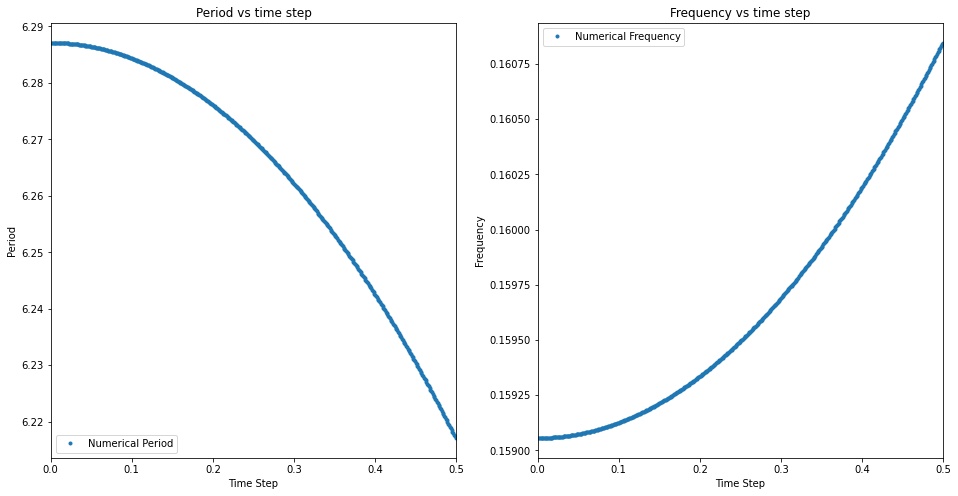

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods01,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods01,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

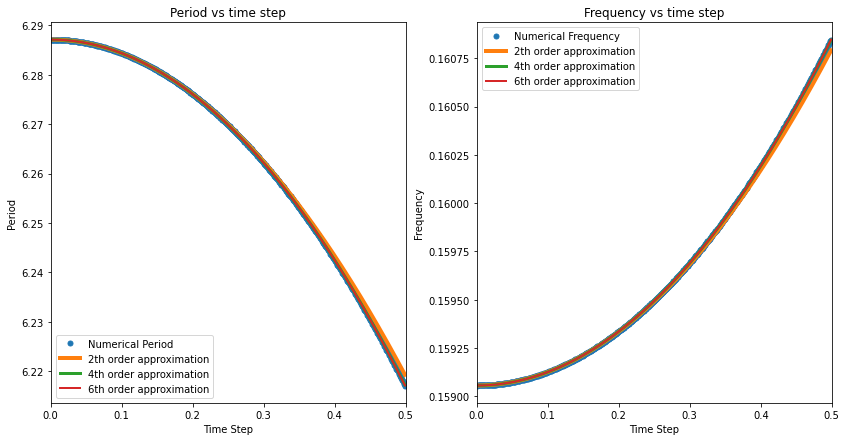

In [21]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods01,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/omega2(dts,0.1),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/omega4(dts,0.1),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/omega6(dts,0.1),
         label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods01,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,omega2(dts,0.1),
        label="2th order approximation",linewidth=4)
plt.plot(dts,omega4(dts,0.1),
        label="4th order approximation",linewidth=3)
plt.plot(dts,omega6(dts,0.1),
        label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.3$

In [22]:
epsilon=0.3
vdp = VanDerPol(epsilon, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 200000

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods03 = np.load(f"data/datapar/eps03-{tf}.npy")
except FileNotFoundError:
    periods03 = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/datapar/eps03-{tf}", periods03)

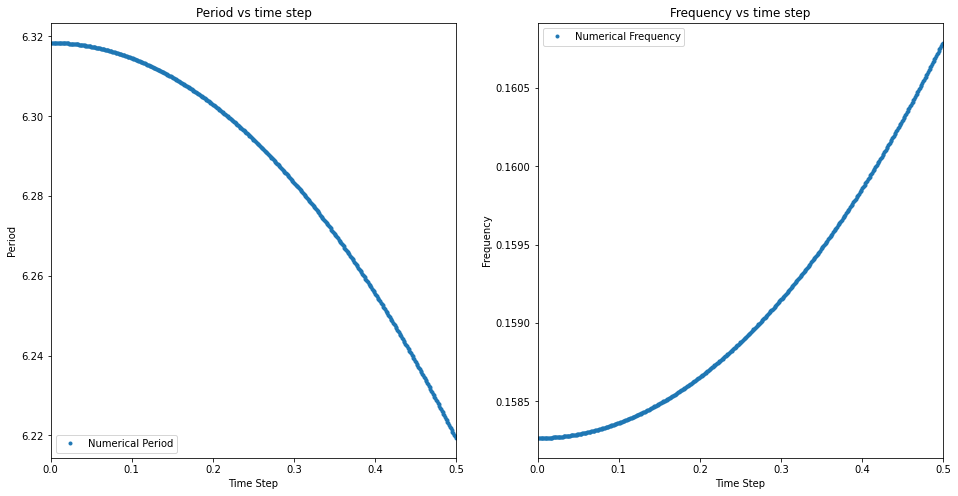

In [23]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods03,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods03,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

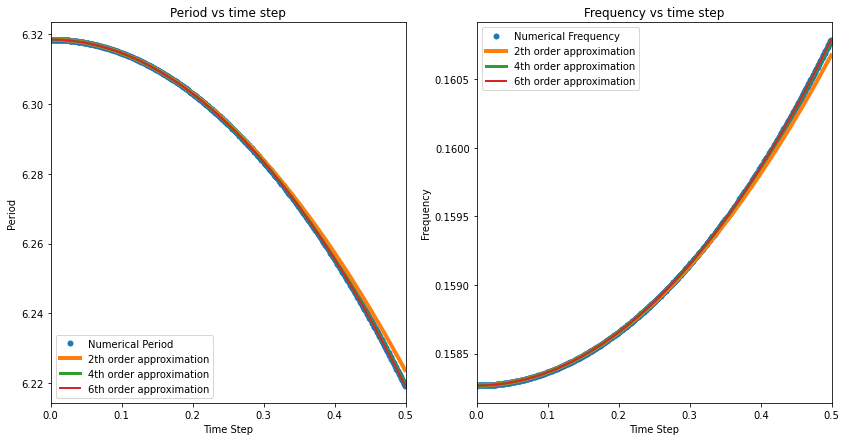

In [24]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods03,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/omega2(dts,epsilon),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/omega4(dts,epsilon),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/omega6(dts,epsilon),
         label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods03,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,omega2(dts,epsilon),
        label="2th order approximation",linewidth=4)
plt.plot(dts,omega4(dts,epsilon),
        label="4th order approximation",linewidth=3)
plt.plot(dts,omega6(dts,epsilon),
        label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.5$

In [26]:
epsilon=0.5
vdp = VanDerPol(epsilon, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 200000

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods05 = np.load(f"data/datapar/eps05-{tf}.npy")
except FileNotFoundError:
    periods05 = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/datapar/eps05-{tf}", periods05)

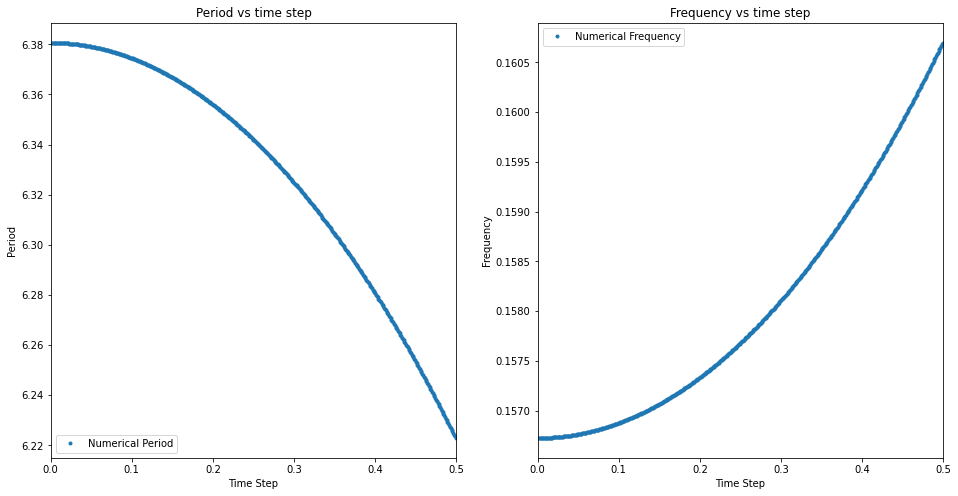

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods05,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods05,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

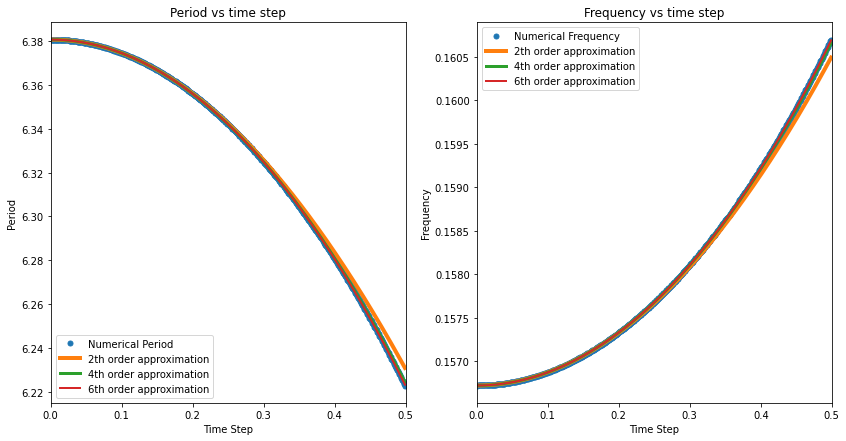

In [28]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods05,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/omega2(dts,epsilon),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/omega4(dts,epsilon),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/omega6(dts,epsilon),
         label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods05,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,omega2(dts,epsilon),
        label="2th order approximation",linewidth=4)
plt.plot(dts,omega4(dts,epsilon),
        label="4th order approximation",linewidth=3)
plt.plot(dts,omega6(dts,epsilon),
        label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.7$

In [29]:
epsilon=0.7
vdp = VanDerPol(epsilon, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 200000

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods07 = np.load(f"data/datapar/eps07-{tf}.npy")
except FileNotFoundError:
    periods07 = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/datapar/eps07-{tf}", periods07)

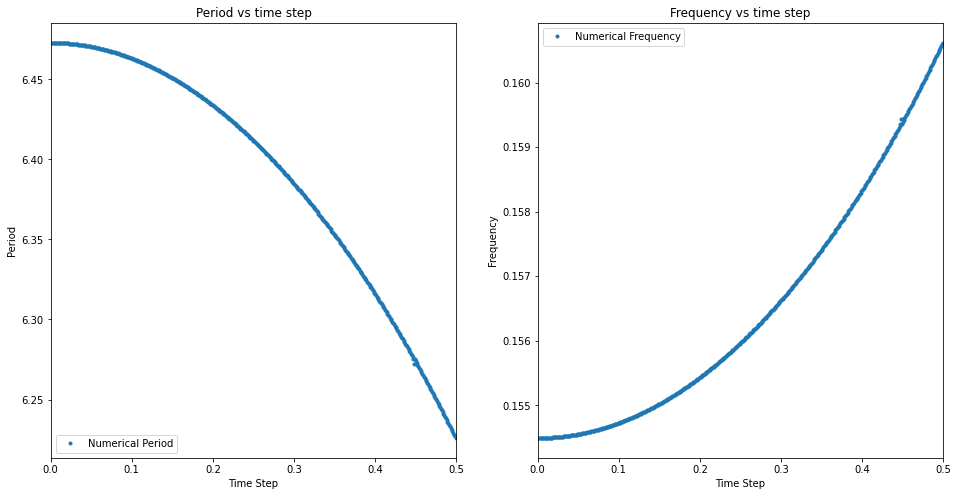

In [30]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods07,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods07,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

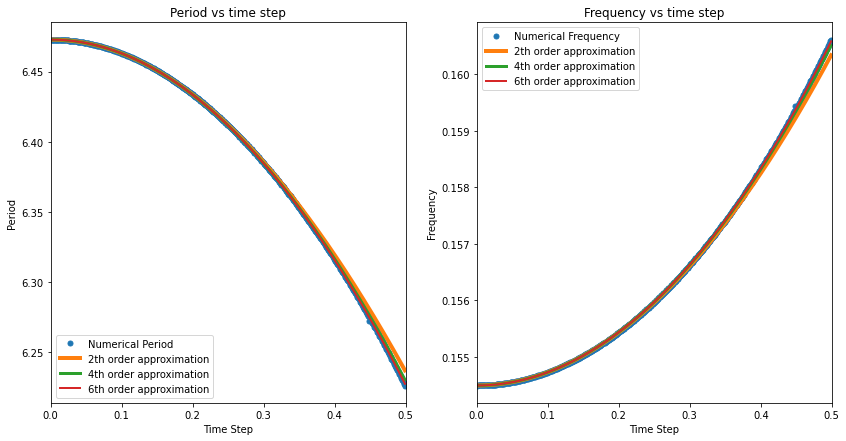

In [31]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods07,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/omega2(dts,epsilon),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/omega4(dts,epsilon),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/omega6(dts,epsilon),
         label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods07,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,omega2(dts,epsilon),
        label="2th order approximation",linewidth=4)
plt.plot(dts,omega4(dts,epsilon),
        label="4th order approximation",linewidth=3)
plt.plot(dts,omega6(dts,epsilon),
        label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 0.9$

In [32]:
epsilon=0.9
vdp = VanDerPol(epsilon, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 200000

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods09 = np.load(f"data/datapar/eps09-{tf}.npy")
except FileNotFoundError:
    periods09 = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/datapar/eps09-{tf}", periods09)

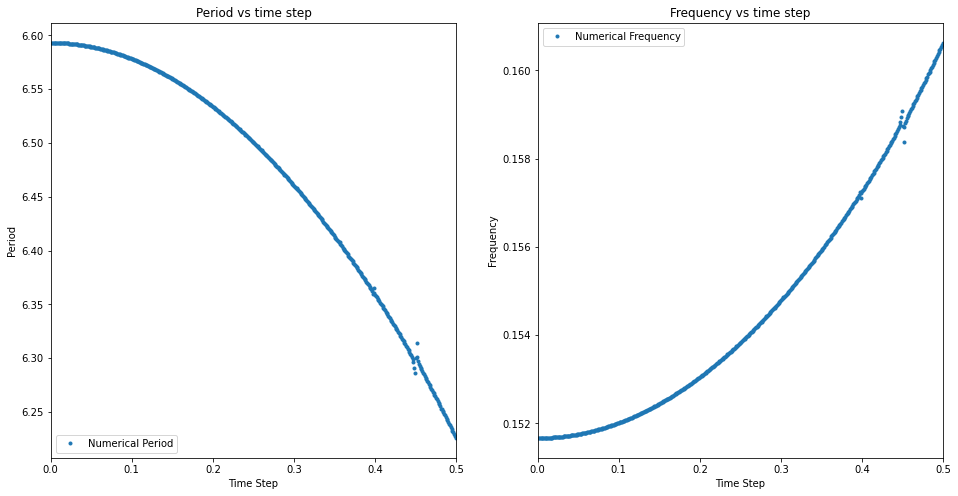

In [33]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods09,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods09,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

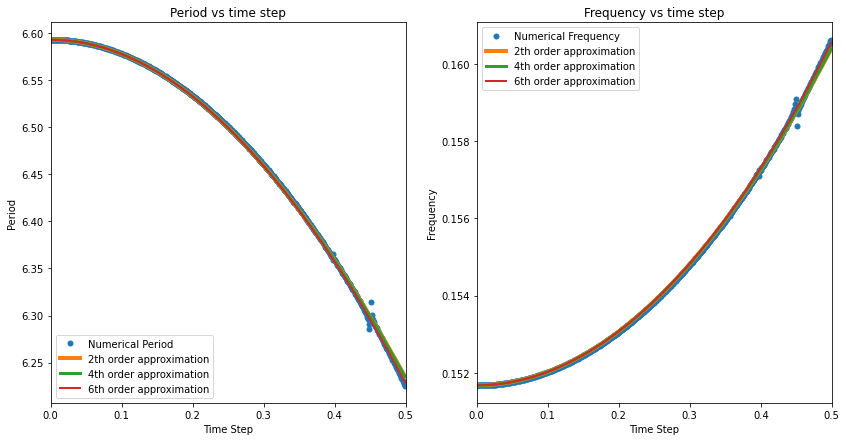

In [34]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods09,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/omega2(dts,epsilon),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/omega4(dts,epsilon),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/omega6(dts,epsilon),
         label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods09,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,omega2(dts,epsilon),
        label="2th order approximation",linewidth=4)
plt.plot(dts,omega4(dts,epsilon),
        label="4th order approximation",linewidth=3)
plt.plot(dts,omega6(dts,epsilon),
        label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## $\epsilon = 1.1$

In [36]:
epsilon=1.1
vdp = VanDerPol(epsilon, 0.0, 0.0)
dts = np.arange(0.001,0.5,0.001)

# XXX: Long integration with tf tf = 20000 
# to have a result in a human time fix tf = 200
tf = 2000000

# p0, q0, s0, t0 = 0.0, 1.0, 1.5, 0.0
p0, q0, s0, t0 = 0.0, 2.0, 0.0, 0.0

# Run only unce to generate the file, otherwise load it from disk
try:
    periods11 = np.load(f"data/datapar/eps11-{tf}.npy")
except FileNotFoundError:
    periods11 = compute_periods(vdp, (p0,q0,s0,t0), dts, tf)
    np.save(f"data/datapar/eps11-{tf}", periods11)

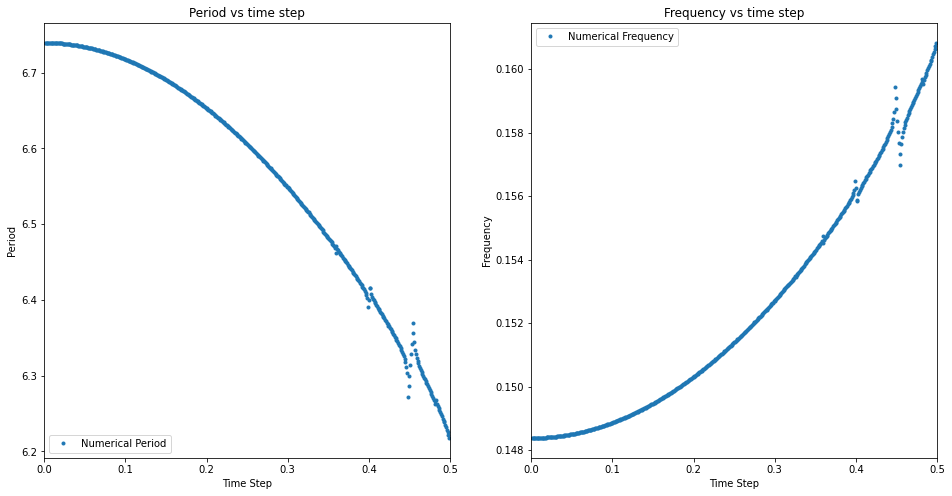

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods11,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods11,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

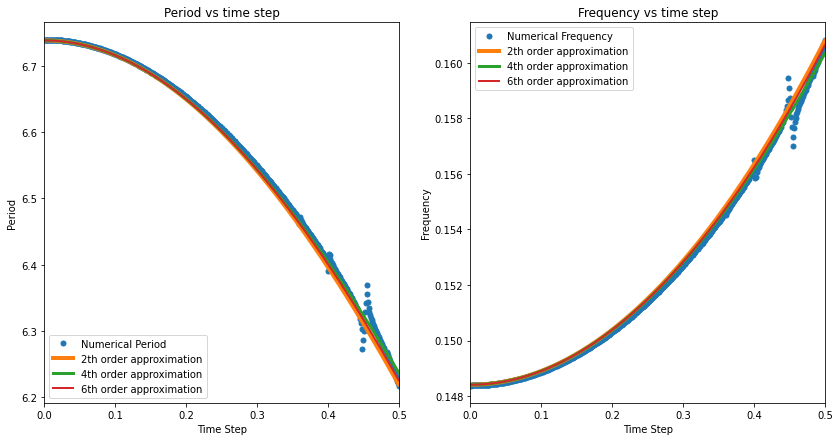

In [38]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dts,periods11,'.',label="Numerical Period",markersize=10)
plt.plot(dts,1/omega2(dts,epsilon),
         label="2th order approximation",linewidth=4)
plt.plot(dts,1/omega4(dts,epsilon),
         label="4th order approximation",linewidth=3)
plt.plot(dts,1/omega6(dts,epsilon),
         label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='lower left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dts,1/periods11,'.',label="Numerical Frequency",markersize=10)
plt.plot(dts,omega2(dts,epsilon),
        label="2th order approximation",linewidth=4)
plt.plot(dts,omega4(dts,epsilon),
        label="4th order approximation",linewidth=3)
plt.plot(dts,omega6(dts,epsilon),
        label="6th order approximation",linewidth=2)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()